#Library Imports

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Input, GlobalAveragePooling2D
from tensorflow.keras import Model
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt



#Functions:

In [ ]:
def generate_bounding_box(img):
  rows = np.any(img, axis = 1)
  cols = np.any(img, axis = 0)

  ###########################################################
  #assumes the image has significant values (non-zero) around the digit.
  '''
  if not np.any(rows) or not np.any(cols):
    return [0.0, 0.0, 1.0, 1.0]
'''
  ymin, ymax = np.where(rows)[0][[0,-1]]
  xmin, xmax = np.where(cols)[0][[0,-1]]

  #Noramalize the corrdinates
  ymin , ymax = ymin / 28.0, ymax / 28.0
  xmin, xmax = xmin / 28.0, xmax / 28.0

  width = xmax - xmin
  height = ymax - ymin


  return [xmin, ymin, width, height]

In [ ]:
def add_random_noise(x, noise_factor=0.2):
    # Randomly generate noise
    noise = np.random.randn(*x.shape) * noise_factor

    # Add noise to the input data (x)
    x_noisy = x + noise

    # Clip the values to ensure they are within the valid range (0 to 1)
    x_noisy = np.clip(x_noisy, 0., 1.)

    return x_noisy


preprocess function with the noise being added

In [ ]:
def preprocess_mnist(add_noise=False):
    # Load the MNIST dataset
    mnist = tf.keras.datasets.mnist
    (x_train, y_train), (x_test, y_test) = mnist.load_data()

    # Normalize and reshape images
    x_train = x_train.reshape(-1, 28, 28, 1).astype('float32') / 255.0
    x_test = x_test.reshape(-1, 28, 28, 1).astype('float32') / 255.0

    # Add random noise if needed
    if add_noise:
        x_train = add_random_noise(x_train)
        x_test = add_random_noise(x_test)

    # Convert y labels to categorical (one-hot encoding)
    y_train = to_categorical(y_train, num_classes=10)
    y_test = to_categorical(y_test, num_classes=10)

    # Generate synthetic bounding box coordinates
    y_train_box = np.array([generate_bounding_box(img.squeeze()) for img in x_train])
    y_test_box = np.array([generate_bounding_box(img.squeeze()) for img in x_test])

    return (x_train, y_train, y_train_box), (x_test, y_test, y_test_box)

In [ ]:
def create_model():
    input_layer = Input(shape=(28, 28, 1))

    # Shared convolutional base
    c = Conv2D(32, (3, 3), activation='relu')(input_layer)
    c = MaxPooling2D((2, 2))(c)
    c = Conv2D(64, (3, 3), activation='relu')(c)
    c = MaxPooling2D((2, 2))(c)
    c = Conv2D(128, (3, 3), activation='relu')(c)
    c = GlobalAveragePooling2D()(c)

    # Classification output
    classification_output = Dense(10, activation='softmax', name='classification')(c)

    # Localization output
    localization_output = Dense(4, name='localization')(c)

    # Define the model
    model = Model(inputs=input_layer, outputs=[classification_output, localization_output])

    # Configures the model with the optimizer, loss functions, and metrics it will use during training.
    model.compile(optimizer='adam',
                  loss={'classification': 'categorical_crossentropy',
                        'localization': 'mean_squared_error'},
                  metrics={'classification': 'accuracy'})

    return model


In [ ]:
def predict_and_display(model , x, y_true, y_true_box, n_samples = 5):
  y_pred, y_pred_box = model.predict(x)

  for i in range(n_samples):
    #classification
    true_label = np.argmax(y_true[i])
    pred_label = np.argmax(y_pred[i])

    #localization
    true_box = y_true_box[i]
    pred_box = y_pred_box[i]

    fig, pt = plt.subplots(1)
    pt.imshow(x[i].reshape(28, 28), cmap = 'gray')

    #True bounding box in green
    rect_true = plt.Rectangle((true_box[0] * 28, true_box[1] * 28), true_box[2] * 28, true_box[3] * 28, linewidth = 2, edgecolor = 'green', facecolor='none')
    pt.add_patch(rect_true)

    #predicted bounding box in red
    rect_pred = plt.Rectangle((pred_box[0] * 28, pred_box[1] * 28), pred_box[2] * 28, pred_box[3] * 28, linewidth = 2, edgecolor = 'red', facecolor='none')
    pt.add_patch(rect_pred)


    pt.set_title(f'True: {true_label}, Pred: {pred_label}')
    plt.show()




#Build & Train the model

## original data

Use the preprocess function

In [ ]:
(x_train,y_train, y_train_box), (x_test,y_test, y_test_box) = preprocess_mnist(add_noise = False)

In [ ]:
model_original = create_model()

# train the model
history_original = model_original.fit(
    x_train,
    {'classification': y_train, 'localization': y_train_box},
    epochs=5,
    batch_size=32,
    validation_data=(x_test, {'classification': y_test, 'localization': y_test_box})
)


Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 79s 40ms/step - classification_accuracy: 0.8222 - loss: 0.5752 - val_classification_accuracy: 0.9734 - val_loss: 0.0970
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 82s 40ms/step - classification_accuracy: 0.9719 - loss: 0.0993 - val_classification_accuracy: 0.9841 - val_loss: 0.0632
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 74s 39ms/step - classification_accuracy: 0.9822 - loss: 0.0624 - val_classification_accuracy: 0.9872 - val_loss: 0.0446
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 81s 39ms/step - classification_accuracy: 0.9873 - loss: 0.0460 - val_classification_accuracy: 0.9877 - val_loss: 0.0440
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 82s 39ms/step - classification_accuracy: 0.9904 - loss: 0.0346 - val_classification_accuracy: 0.9905 - val_loss: 0.0293


In [ ]:
print(x_train.shape)
print(y_train.shape)
print(y_train_box.shape)
print(x_test.shape)
print(y_test.shape)
print(y_test_box.shape)

(60000, 28, 28, 1)
(60000, 10)
(60000, 4)
(10000, 28, 28, 1)
(10000, 10)
(10000, 4)


In [ ]:
##check for the data balance
# Assuming y_test is the one-hot encoded test labels
y_true_labels = np.argmax(y_train, axis=1)  # Convert to class labels

# Count occurrences of each digit
unique, counts = np.unique(y_true_labels, return_counts=True)
digit_counts = dict(zip(unique, counts))

# Print the counts
print(digit_counts)

{0: 5923, 1: 6742, 2: 5958, 3: 6131, 4: 5842, 5: 5421, 6: 5918, 7: 6265, 8: 5851, 9: 5949}


313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step


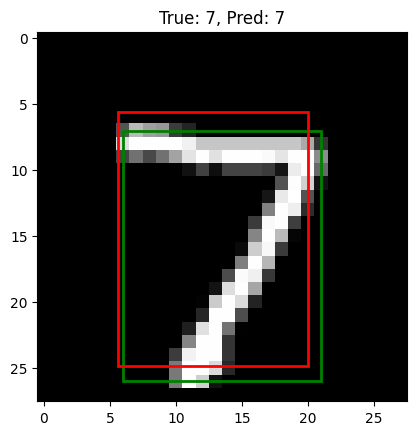

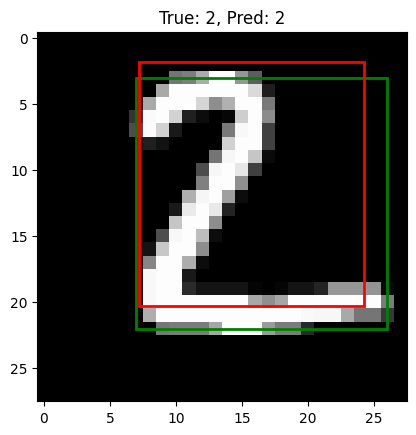

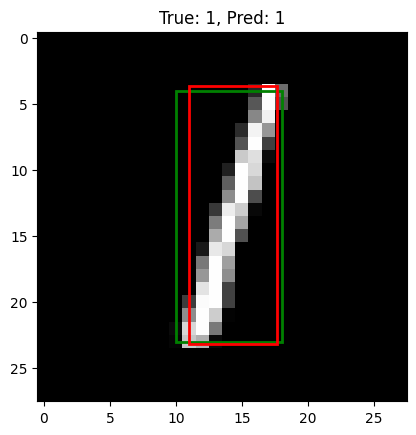

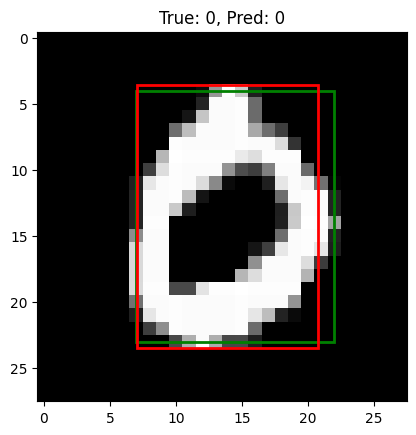

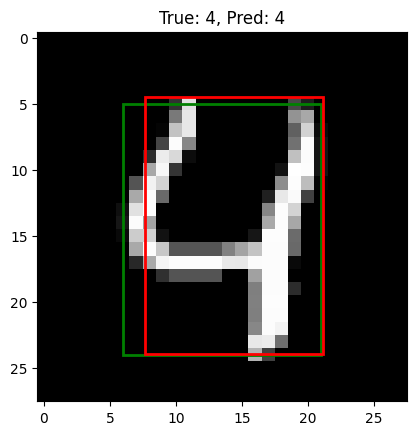

In [ ]:
#test the model
predict_and_display(model_original, x_test,y_test, y_test_box)

##noisy data

In [ ]:
(x_train_noisy, y_train, y_train_box_noisy), (x_test_noisy,y_test, y_test_box_noisy) = preprocess_mnist(add_noise=True)
model_noisy = create_model()

#train the model
history_noisy = model_noisy.fit(
    x_train_noisy,
    {'classification': y_train, 'localization': y_train_box_noisy},
    epochs=5,
    batch_size=32,
    validation_data=(x_test_noisy, {'classification': y_test, 'localization': y_test_box_noisy})
)

Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 81s 42ms/step - classification_accuracy: 0.7294 - loss: 0.8314 - val_classification_accuracy: 0.9569 - val_loss: 0.1470
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 76s 39ms/step - classification_accuracy: 0.9635 - loss: 0.1246 - val_classification_accuracy: 0.9732 - val_loss: 0.0942
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 84s 40ms/step - classification_accuracy: 0.9769 - loss: 0.0826 - val_classification_accuracy: 0.9840 - val_loss: 0.0571
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 84s 41ms/step - classification_accuracy: 0.9822 - loss: 0.0581 - val_classification_accuracy: 0.9838 - val_loss: 0.0549
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 81s 40ms/step - classification_accuracy: 0.9859 - loss: 0.0470 - val_classification_accuracy: 0.9884 - val_loss: 0.0401


313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step


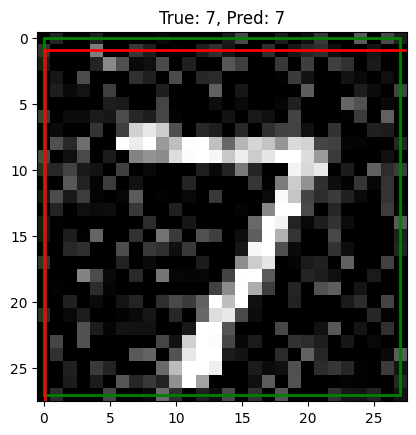

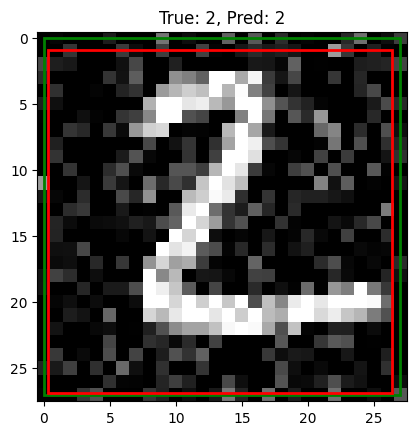

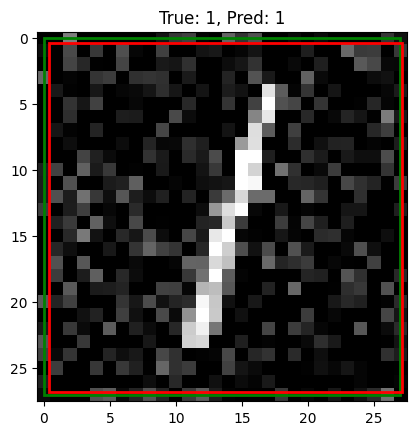

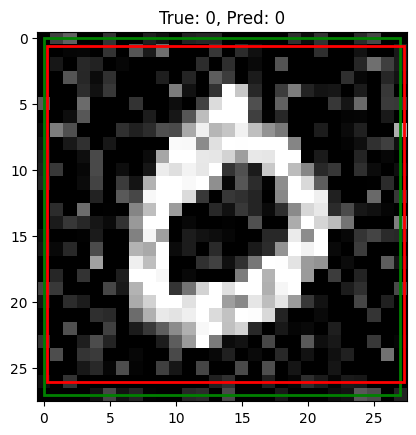

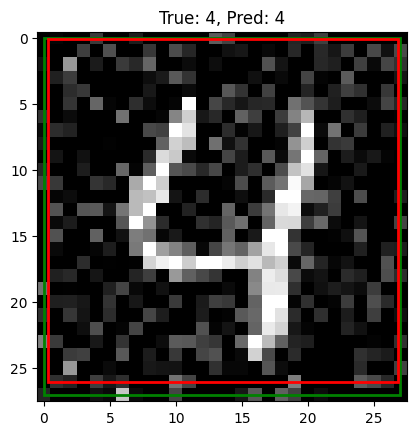

In [ ]:
#test the model
predict_and_display(model_noisy, x_test_noisy,y_test, y_test_box_noisy)

##Comparison

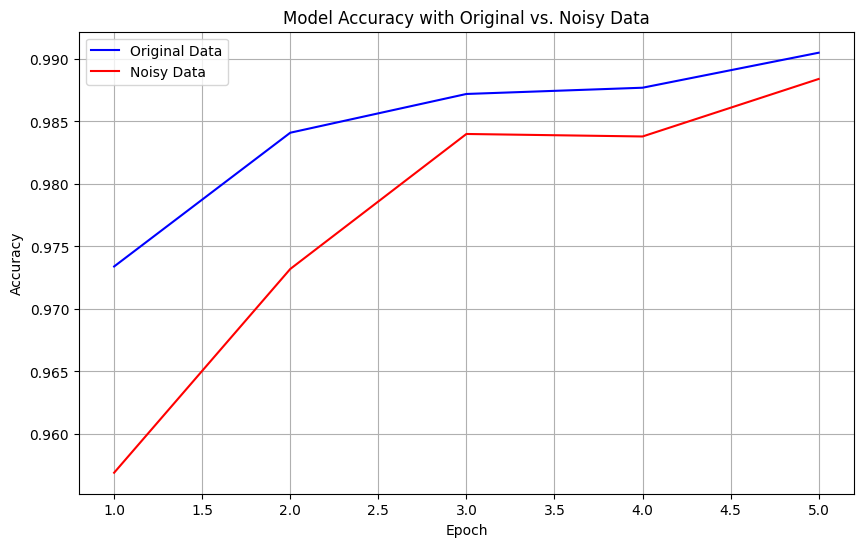

In [ ]:
epochs = range(1, 6)
plt.figure(figsize=(10, 6))
plt.plot(epochs, history_original.history['val_classification_accuracy'], 'b-', label='Original Data')
plt.plot(epochs, history_noisy.history['val_classification_accuracy'], 'r-', label='Noisy Data')
plt.title('Model Accuracy with Original vs. Noisy Data')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


#Save and Download the model

In [ ]:
model_original.save('/content/MNIST_modell.h5')

In [ ]:
from google.colab import files
files.download('/content/MNIST_modell.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#Test using external images

In [ ]:
from PIL import Image

In [ ]:
def preprocess_image(image_path):
    img = Image.open(image_path).convert('L')
    img = img.resize((28, 28))
    img_array = np.array(img).astype('float32') / 255.0
    img_array = img_array.reshape(1, 28, 28, 1)  # Reshape for the model
    return img_array

In [ ]:
def predict_image(model, image_path):
    # Preprocess the single image
    img_array = preprocess_image(image_path)
    # Predict for the single image
    classification, localization = model_original.predict(img_array)

    # Display results
    plt.figure()
    plt.imshow(img_array.reshape(28, 28), cmap='gray')

    # Predicted bounding box in red
    #localization[0] accesses the bounding box coordinates for that first (and only) image in the batch
    pred_box = localization[0]
    rect_pred = plt.Rectangle((pred_box[0] * 28, pred_box[1] * 28), pred_box[2] * 28, pred_box[3] * 28, linewidth=2, edgecolor='red', facecolor='none')
    plt.gca().add_patch(rect_pred)

    #classification[0] accesses the predicted probabilities for the first (and only) image in the batch.
    pred_label = np.argmax(classification[0])
    plt.title(f'Predicted Label: {pred_label}')
    plt.show()

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Screenshot 2024-09-11 210049.png to Screenshot 2024-09-11 210049 (4).png
Saving Screenshot 2024-09-11 214808.png to Screenshot 2024-09-11 214808 (4).png
Saving Screenshot 2024-09-11 231735.png to Screenshot 2024-09-11 231735 (3).png
Saving Screenshot 2024-09-11 231747.png to Screenshot 2024-09-11 231747 (3).png
Saving Screenshot 2024-09-11 231757.png to Screenshot 2024-09-11 231757 (3).png
Saving Screenshot 2024-09-11 231929.png to Screenshot 2024-09-11 231929 (3).png
Saving Screenshot 2024-09-11 231948.png to Screenshot 2024-09-11 231948 (3).png
Saving Screenshot 2024-09-11 232349.png to Screenshot 2024-09-11 232349 (3).png
Saving Screenshot 2024-09-11 232720.png to Screenshot 2024-09-11 232720 (3).png
Saving Screenshot 2024-09-11 233117.png to Screenshot 2024-09-11 233117 (3).png


Uploaded image: Screenshot 2024-09-11 210049 (4).png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


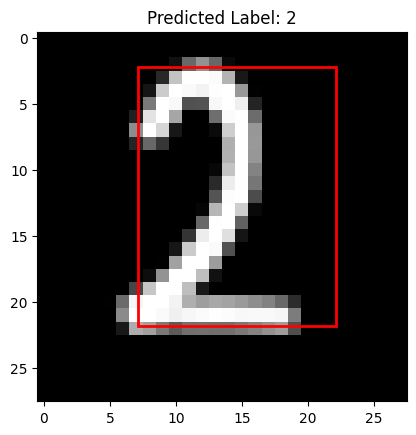

Uploaded image: Screenshot 2024-09-11 214808 (4).png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


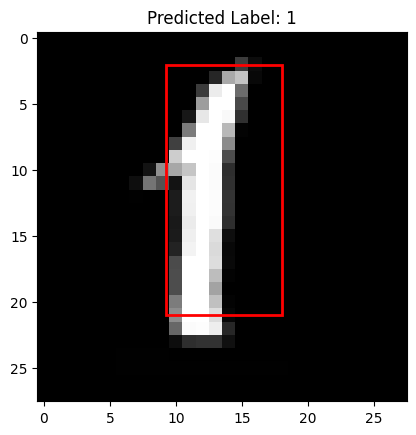

Uploaded image: Screenshot 2024-09-11 231735 (3).png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


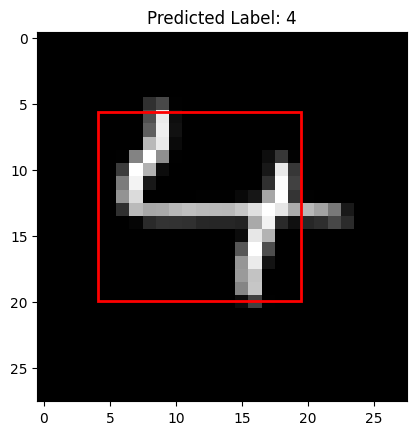

Uploaded image: Screenshot 2024-09-11 231747 (3).png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


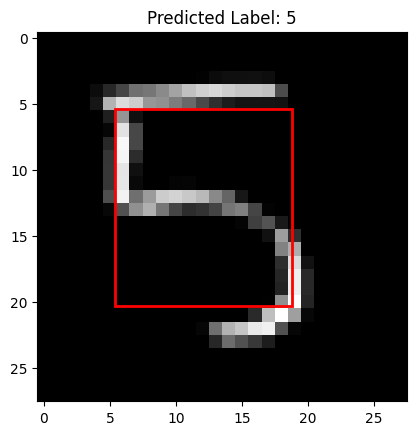

Uploaded image: Screenshot 2024-09-11 231757 (3).png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


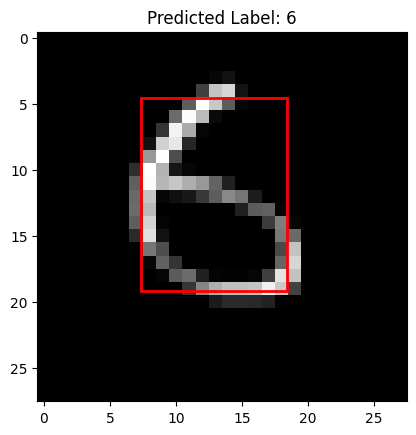

Uploaded image: Screenshot 2024-09-11 231929 (3).png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


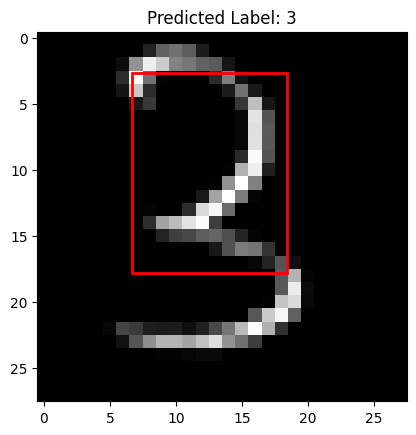

Uploaded image: Screenshot 2024-09-11 231948 (3).png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


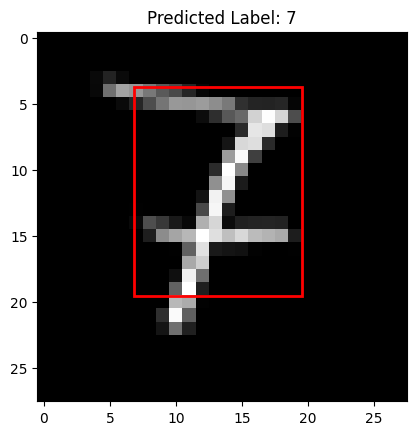

Uploaded image: Screenshot 2024-09-11 232349 (3).png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


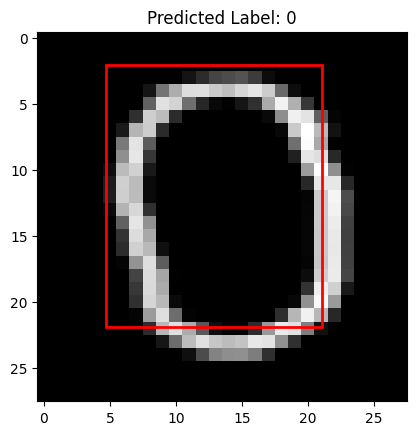

Uploaded image: Screenshot 2024-09-11 232720 (3).png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


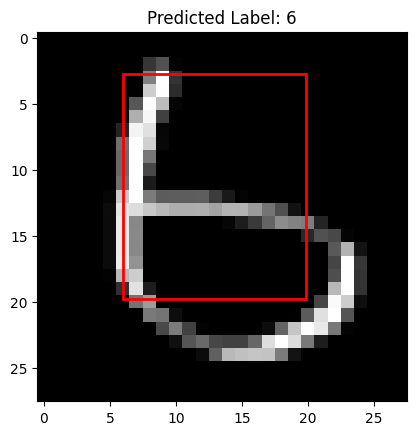

Uploaded image: Screenshot 2024-09-11 233117 (3).png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


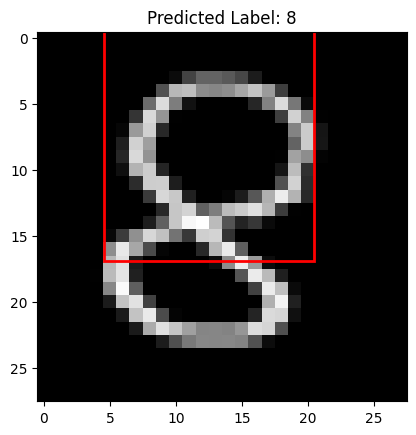

In [ ]:
# Make predictions on uploaded images
for image_name in uploaded.keys():
    print(f'Uploaded image: {image_name}')
    predict_image(model_original, image_name)